# Normal Normal

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

import beanmachine.ppl as bm

class NormalNormal:
    @bm.random_variable
    def mu(self):
        return dist.Normal(0, 1)
    
    @bm.random_variable
    def x(self, i):
        return dist.Normal(self.mu(), 1)
model = NormalNormal()
queries = [model.mu()]
obs = {
    model.x(0): torch.tensor(10.0),
}

def true_log_prob(x):
    tau_0 = 1.0**-2
    tau_1 = 1.0**-2
    return dist.Normal((tau_1 / (tau_0 + tau_1)) * 10.0, (tau_0 + tau_1)**-1).log_prob(x)
    


In [2]:
from beanmachine.ppl.experimental.vi.VariationalInfer import MeanFieldVariationalInference

vi = MeanFieldVariationalInference()
vi_dicts = vi.infer(queries, obs, base_dist=dist.Normal, base_args={
    'loc': nn.Parameter(torch.tensor(0.)),
    'scale': torch.tensor(1.),
}, num_iter=100, lr=1e-1)

In [3]:
fs = vi_dicts[model.mu()].flow_stack
fs.base_dist(**fs.base_args)

Normal(loc: -0.024408599361777306, scale: 1.0)

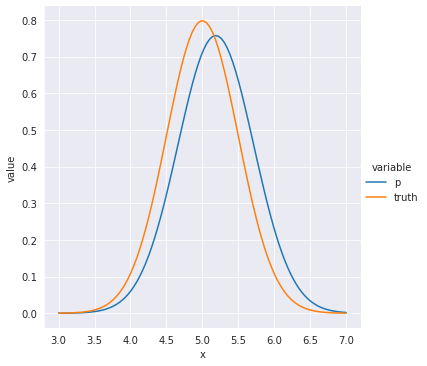

In [4]:
x = torch.linspace(3, 7).unsqueeze(1)
p = torch.exp(vi_dicts[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p": p.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

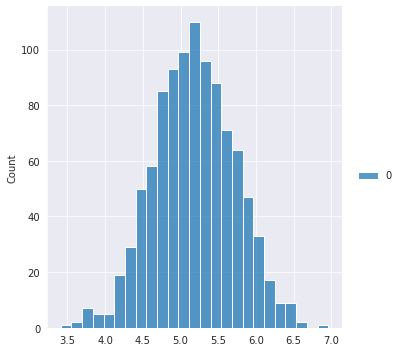

In [5]:
sns.displot(vi_dicts[model.mu()].sample((1000,1)).detach().numpy())

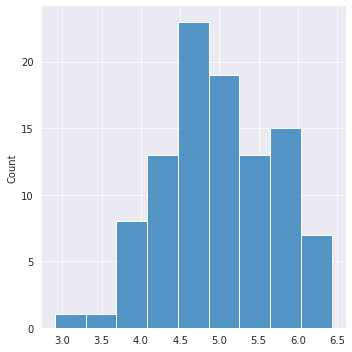

In [6]:
import beanmachine.ppl as bm

mcmc = bm.SingleSiteHamiltonianMonteCarlo(path_length=10)
samples = mcmc.infer(queries, obs, num_samples=100, num_chains=1)
sns.displot(samples[model.mu()].flatten().numpy())

# Using a heavy-tailed base distribution

In [7]:
import torch
import torch.nn as nn
from beanmachine.ppl.experimental.vi.VariationalInfer import MeanFieldVariationalInference

vi = MeanFieldVariationalInference()

vi_dicts_student = vi.infer(
    queries, obs, 
    base_dist=dist.StudentT,
    base_args={
        #'df': torch.tensor(1000000.0),
        'df': nn.Parameter(torch.tensor(10.0)),
        'loc': torch.tensor(0.0),
        #'loc': nn.Parameter(torch.tensor(0.0)),
        #'scale': torch.tensor(1.0),
        #'scale': nn.Parameter(torch.tensor(1.0)),
    },
    num_iter=100, lr=1)

#)

In [8]:
fs = vi_dicts_student[model.mu()].flow_stack
fs.base_dist(**fs.base_args)

StudentT(df: 16.44184684753418, loc: 0.0, scale: 1.0)

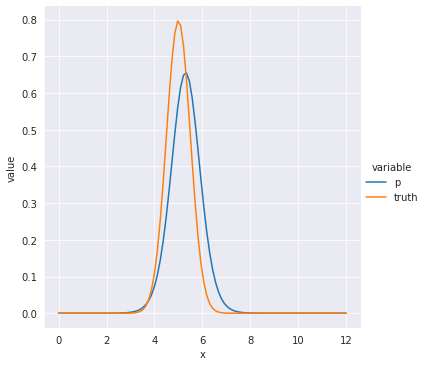

In [9]:
x = torch.linspace(0, 12).unsqueeze(1)
p = torch.exp(vi_dicts_student[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p": p.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

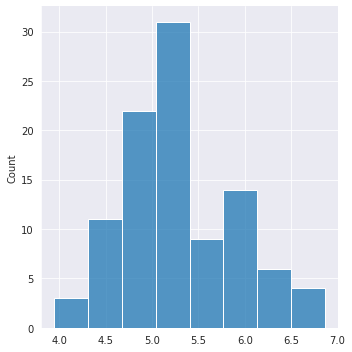

In [10]:
sns.displot(vi_dicts_student[model.mu()].sample((100,)).detach().numpy().flatten())